In [10]:
import os
import pandas as pd

# Define new folder paths
base_folder = "C:/FRR40/rat25-main/sample_data"
detections_folder = os.path.join(base_folder, "detections")
objects_folder = os.path.join(base_folder, "objects")
ego_motion_folder = os.path.join(base_folder, "ego_motion")
processed_folder = os.path.join(base_folder, "processed")  # For saving new processed files
os.makedirs(processed_folder, exist_ok=True)

# Columns to retain
detections_columns = [
    "timestamp", "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity", "radialVelocityDomainMax"
]
objects_columns = [
    "timestamp", "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "status_measurement", "status_movement", "overdrivable", "underdrivable",
    "header.origin.x", "header.origin.y", "header.origin.z",
    "header.origin.roll", "header.origin.pitch", "header.origin.yaw", "reference_point"
]
ego_motion_columns = [
    "timestamp", "RotationRates.yawRateVehicleBody.value", "Velocity.SpeedCog.SpeedCog"
]

# Function to filter files
def filter_files(folder, columns_to_keep, output_subfolder):
    output_path = os.path.join(processed_folder, output_subfolder)
    os.makedirs(output_path, exist_ok=True)
    filtered_data = {}

    files = sorted([f for f in os.listdir(folder) if f.endswith(".p")])
    for file in files:
        file_path = os.path.join(folder, file)
        print(f"Processing file: {file}")
        
        # Load data
        data = pd.read_pickle(file_path)
        
        # Filter relevant columns
        filtered_df = data[columns_to_keep]
        filtered_data[file] = filtered_df
        
        # Save filtered file
        save_path = os.path.join(output_path, file)
        filtered_df.to_pickle(save_path)
        print(f"Filtered data saved to: {save_path}")

    return filtered_data

# Filter detections, objects, and ego motion files
filtered_detections = filter_files(detections_folder, detections_columns, "filtered_detections")
filtered_objects = filter_files(objects_folder, objects_columns, "filtered_objects")
filtered_ego_motion = filter_files(ego_motion_folder, ego_motion_columns, "filtered_ego_motion")

# Verify the results
print("\nFiltered files are saved in the 'processed' folder.")


Processing file: frr40_detections_0.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_0.p
Processing file: frr40_detections_1.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_1.p
Processing file: frr40_detections_2.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_2.p
Processing file: frr40_detections_3.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_3.p
Processing file: frr40_objects_0.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_objects\frr40_objects_0.p
Processing file: frr40_objects_1.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_objects\frr40_objects_1.p
Processing file: frr40_objects_2.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_objects\frr40_objects_2.p
Processing f

In [11]:
from datetime import timedelta

# Define the folder paths
filtered_detections_folder = os.path.join(processed_folder, "filtered_detections")
filtered_objects_folder = os.path.join(processed_folder, "filtered_objects")
filtered_ego_motion_folder = os.path.join(processed_folder, "filtered_ego_motion")
combined_data_folder = os.path.join(processed_folder, "combined_data")
os.makedirs(combined_data_folder, exist_ok=True)

# Function to find the closest timestamp in ego motion
def find_closest_timestamp(timestamp, ego_motion_df):
    closest_row = ego_motion_df.iloc[(ego_motion_df['timestamp'] - timestamp).abs().argsort()[:1]]
    return closest_row.iloc[0]

# Function to combine data
def combine_dataframes(detections_folder, objects_folder, ego_motion_folder, output_folder):
    combined_data = []

    # Load filtered files
    detection_files = sorted([f for f in os.listdir(detections_folder) if f.endswith(".p")])
    object_files = sorted([f for f in os.listdir(objects_folder) if f.endswith(".p")])
    ego_motion_files = sorted([f for f in os.listdir(ego_motion_folder) if f.endswith(".p")])

    # Ensure matching file pairs
    for det_file, obj_file in zip(detection_files, object_files):
        print(f"Combining {det_file} and {obj_file}...")

        # Load detections and objects
        det_path = os.path.join(detections_folder, det_file)
        obj_path = os.path.join(objects_folder, obj_file)
        detections_df = pd.read_pickle(det_path)
        objects_df = pd.read_pickle(obj_path)

        # Merge detections and objects on timestamp
        merged_df = pd.merge(detections_df, objects_df, on="timestamp", suffixes=("_det", "_obj"))

        # Find and match ego motion data
        closest_ego_motion = []
        for _, row in merged_df.iterrows():
            timestamp = row["timestamp"]
            ego_motion_data = None

            for ego_file in ego_motion_files:
                ego_path = os.path.join(ego_motion_folder, ego_file)
                ego_motion_df = pd.read_pickle(ego_path)

                try:
                    closest_row = find_closest_timestamp(timestamp, ego_motion_df)
                    ego_motion_data = {
                        "yaw_rate": closest_row["RotationRates.yawRateVehicleBody.value"],
                        "ego_speed": closest_row["Velocity.SpeedCog.SpeedCog"]
                    }
                    break
                except Exception as e:
                    print(f"No matching ego motion data for timestamp {timestamp}: {e}")

            closest_ego_motion.append(ego_motion_data)

        # Add ego motion data to the merged dataframe
        ego_motion_df = pd.DataFrame(closest_ego_motion)
        merged_df = pd.concat([merged_df, ego_motion_df.reset_index(drop=True)], axis=1)

        # Save the combined file
        save_path = os.path.join(output_folder, f"combined_{det_file}")
        merged_df.to_pickle(save_path)
        combined_data.append(merged_df)
        print(f"Combined data saved to: {save_path}")

    return combined_data

# Combine dataframes
final_combined_data = combine_dataframes(
    filtered_detections_folder,
    filtered_objects_folder,
    filtered_ego_motion_folder,
    combined_data_folder
)

# Verify combined data
print(f"\nCombined data saved in: {combined_data_folder}")


Combining frr40_detections_0.p and frr40_objects_0.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_0.p
Combining frr40_detections_1.p and frr40_objects_1.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_1.p
Combining frr40_detections_2.p and frr40_objects_2.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_2.p
Combining frr40_detections_3.p and frr40_objects_3.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_3.p

Combined data saved in: C:/FRR40/rat25-main/sample_data\processed\combined_data


In [1]:
import os
import pandas as pd
import numpy as np
import ast  # For safely parsing strings to lists

def transform_coordinates_vcs_to_scs(data, save_path):
    """
    Transforms object coordinates from VCS to SCS for each radar cycle.
    Uses scalar sensor position and orientation for transformation.
    """
    # Add new columns for transformed coordinates
    data["transformed_x"] = None
    data["transformed_y"] = None

    for idx, row in data.iterrows():
        try:
            # Ensure x and y are list-based
            x_coords = row["x"]
            y_coords = row["y"]

            if isinstance(x_coords, str):  # Convert string representation of list
                x_coords = ast.literal_eval(x_coords)
            if isinstance(y_coords, str):  # Convert string representation of list
                y_coords = ast.literal_eval(y_coords)

            if not isinstance(x_coords, (list, np.ndarray)) or not isinstance(y_coords, (list, np.ndarray)):
                raise ValueError("x and y must be list-based.")

            # Convert x and y to NumPy arrays
            x_coords = np.array(x_coords)
            y_coords = np.array(y_coords)

            # Sensor's position and orientation
            origin_x = row["header.origin.x"]
            origin_y = row["header.origin.y"]
            yaw = row["header.origin.yaw"]

            # Translation: Shift the VCS coordinates to the sensor's origin
            x_translated = x_coords - origin_x
            y_translated = y_coords - origin_y

            # Rotation: Apply the sensor's orientation to align with SCS
            x_scs = x_translated * np.cos(yaw) + y_translated * np.sin(yaw)
            y_scs = -x_translated * np.sin(yaw) + y_translated * np.cos(yaw)

            # Store the transformed coordinates as lists
            data.at[idx, "transformed_x"] = x_scs.tolist()
            data.at[idx, "transformed_y"] = y_scs.tolist()

        except Exception as e:
            print(f"Error transforming row {idx}: {e}")
            data.at[idx, "transformed_x"] = None
            data.at[idx, "transformed_y"] = None

    print("Coordinate transformation completed.")
    data.to_pickle(save_path)
    print(f"Transformed data saved to: {save_path}")

# Paths to input and output files
input_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\combined_frr40_detections_0.p"
output_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_combined_frr40_detections_0.p"

# Load the data
data = pd.read_pickle(input_file)

# Transform the coordinates and save the transformed data
transform_coordinates_vcs_to_scs(data, output_file)

# Inspect transformed data
transformed_data = pd.read_pickle(output_file)
print(transformed_data[["x", "y", "transformed_x", "transformed_y"]].head())


Coordinate transformation completed.
Transformed data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_combined_frr40_detections_0.p
                                                   x  \
0  [10.74, 27.42, 38.95, 8.4, 14.429999, 22.72, 2...   
1  [10.71, 27.92, 39.18, 8.46, 14.41, 22.699999, ...   
2  [10.559999, 28.359999, 39.53, 8.51, 14.679999,...   
3  [10.469999, 39.79, 40.309998, 8.58, 14.63, 22....   
4  [10.58, 39.76, 8.63, 14.69, 22.71, 26.359999, ...   

                                                   y  \
0  [-1.61, 0.31, 0.45999998, 4.46, -7.87, -9.0, 1...   
1  [-1.62, -0.53999996, 0.21, 4.46, -7.79, -9.03,...   
2  [-1.5799999, -1.02, -0.47, 4.45, -7.77, -9.059...   
3  [-1.56, -0.89, 10.76, 4.46, -7.79, -9.059999, ...   
4  [-1.55, 11.599999, 4.46, -7.81, -9.08, 16.24, ...   

                                       transformed_x  \
0  [7.22599983215332, 23.9060001373291, 35.436000...   
1  [7.196000099182129, 24.4060001373291, 35.66600...


--- Plotting Old vs. Transformed Coordinates ---


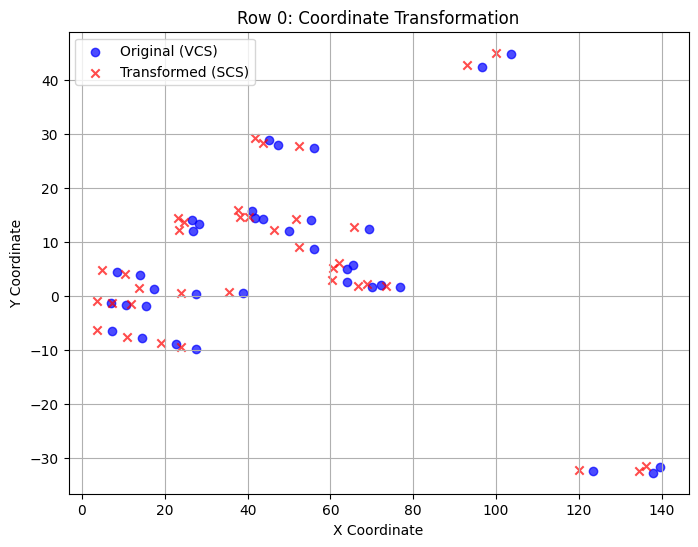

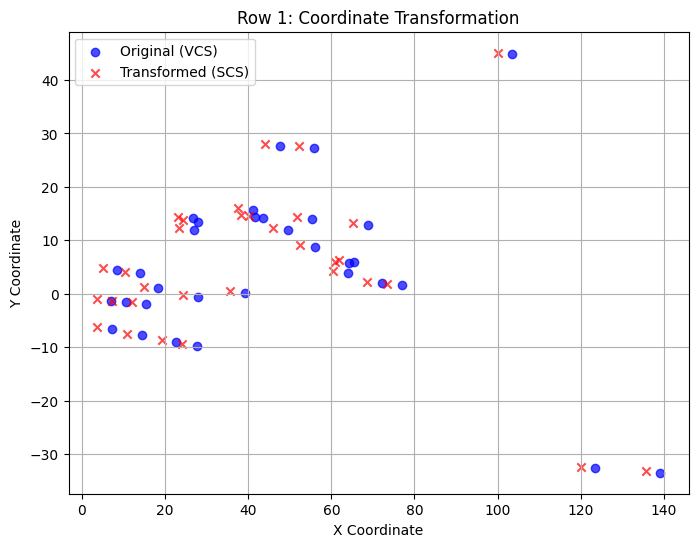

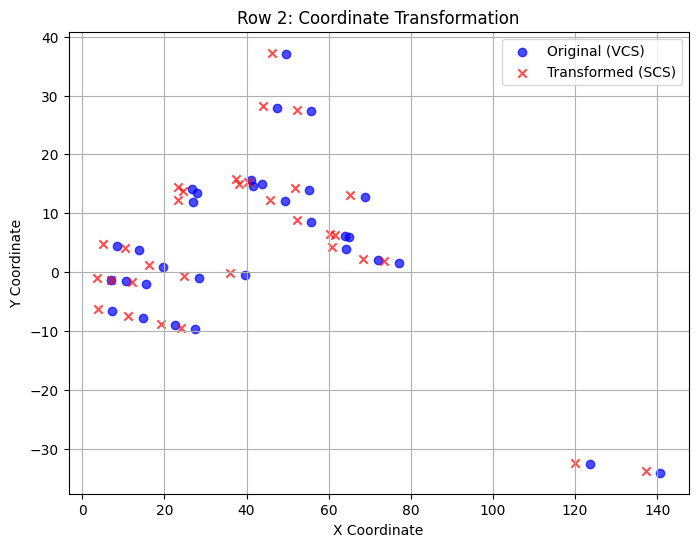

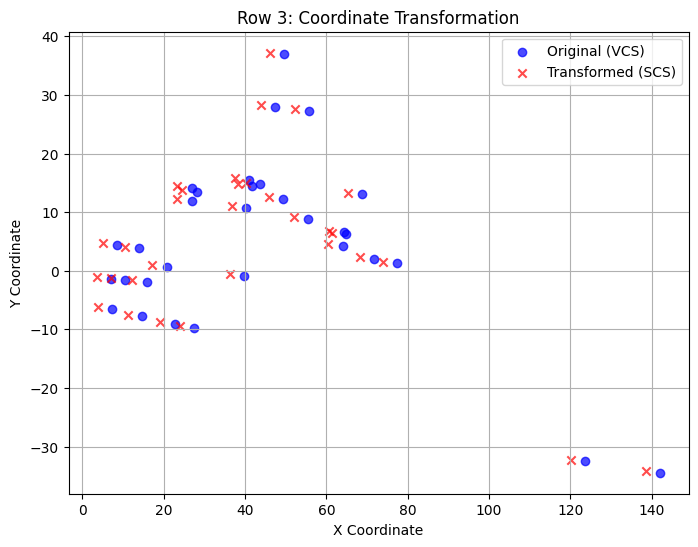

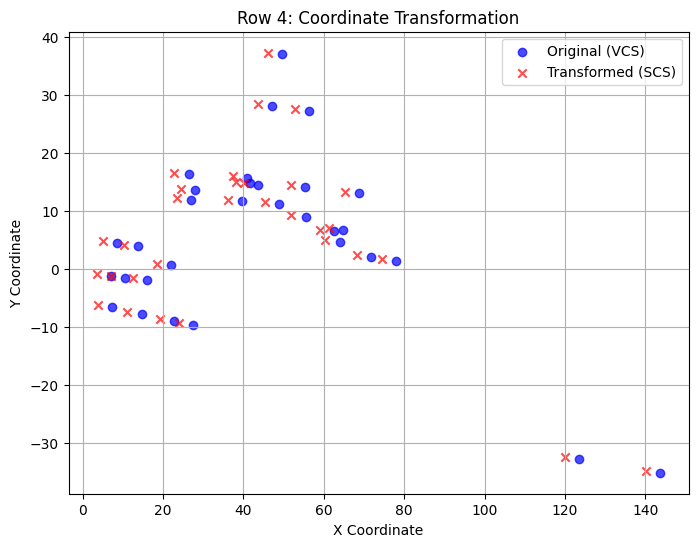

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_transformation_with_conversion(file_path, rows_to_plot=5):
    """
    Plots the old (VCS) and transformed (SCS) coordinates after ensuring they are in a suitable format.
    """
    df = pd.read_pickle(file_path)

    print(f"\n--- Plotting Old vs. Transformed Coordinates ---")

    for idx, row in df.head(rows_to_plot).iterrows():
        try:
            # Extract coordinates
            original_x = row["x"]
            original_y = row["y"]
            transformed_x = row["transformed_x"]
            transformed_y = row["transformed_y"]

            # Ensure they are in list or array format
            if isinstance(original_x, np.ndarray):
                original_x = original_x.tolist()
            if isinstance(original_y, np.ndarray):
                original_y = original_y.tolist()
            if isinstance(transformed_x, np.ndarray):
                transformed_x = transformed_x.tolist()
            if isinstance(transformed_y, np.ndarray):
                transformed_y = transformed_y.tolist()

            # Validate and convert non-list formats
            if not isinstance(original_x, list) or not isinstance(original_y, list):
                print(f"Converting original coordinates for row {idx}.")
                original_x = list(original_x)
                original_y = list(original_y)
            if not isinstance(transformed_x, list) or not isinstance(transformed_y, list):
                print(f"Converting transformed coordinates for row {idx}.")
                transformed_x = list(transformed_x)
                transformed_y = list(transformed_y)

            # Plot the coordinates
            plt.figure(figsize=(8, 6))
            plt.scatter(original_x, original_y, label="Original (VCS)", marker="o", alpha=0.7, color="blue")
            plt.scatter(transformed_x, transformed_y, label="Transformed (SCS)", marker="x", alpha=0.7, color="red")
            plt.title(f"Row {idx}: Coordinate Transformation")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error plotting row {idx}: {e}")

# File path to validate
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_combined_frr40_detections_0.p"

# Run the updated plot function
plot_transformation_with_conversion(file_path, rows_to_plot=5)


In [3]:
import os
import pandas as pd
from shapely import geometry, affinity
import numpy as np

# Function to create polygons and calculate centroids
def create_polygons(x, y, ref_points, lengths, widths, orientations):
    centroids = []
    for obj_x, obj_y, ref_point, length, width, orientation in zip(x, y, ref_points, lengths, widths, orientations):
        try:
            orientation_deg = orientation * 180 / np.pi
            if ref_point == 0:
                poly = geometry.Polygon([[obj_x, obj_y], [obj_x - length, obj_y],
                                         [obj_x - length, obj_y - width], [obj_x, obj_y - width]])
            elif ref_point == 1:
                poly = geometry.Polygon([[obj_x, obj_y + width / 2], [obj_x - length, obj_y + width / 2],
                                         [obj_x - length, obj_y - width / 2], [obj_x, obj_y - width / 2]])
            elif ref_point == 2:
                poly = geometry.Polygon([[obj_x, obj_y + width], [obj_x - length, obj_y + width],
                                         [obj_x - length, obj_y], [obj_x, obj_y]])
            elif ref_point == 3:
                poly = geometry.Polygon([[obj_x + length / 2, obj_y + width], [obj_x - length / 2, obj_y + width],
                                         [obj_x - length / 2, obj_y], [obj_x + length / 2, obj_y]])
            else:
                # Default square if ref_point is unknown
                poly = geometry.Polygon([[obj_x + 1, obj_y + 1], [obj_x - 1, obj_y + 1],
                                         [obj_x - 1, obj_y - 1], [obj_x + 1, obj_y - 1]])

            poly = affinity.rotate(poly, orientation_deg, origin=(obj_x, obj_y))
            centroids.append((poly.centroid.x, poly.centroid.y))
        except Exception as e:
            print(f"Error processing object with x={obj_x}, y={obj_y}, ref_point={ref_point}: {e}")
            centroids.append(None)

    return centroids

# Load the file with the transformed coordinates
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_combined_frr40_detections_0.p"
df = pd.read_pickle(file_path)

# Ensure the `reference_point` column is expanded correctly
df["reference_point"] = df["reference_point"].apply(lambda x: [item[0] for item in x])

# Apply centroid calculation
def calculate_centroids(row):
    return create_polygons(row["transformed_x"], row["transformed_y"], row["reference_point"],
                           row["length_edge_mean"], row["width_edge_mean"], row["orientation"])

df["centroids"] = df.apply(calculate_centroids, axis=1)

# Save the updated file
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_combined_frr40_detections_0.p"
df.to_pickle(output_path)

# Print sample rows for validation
print("Sample Data with Centroids:")
print(df[["length_edge_mean", "width_edge_mean", "centroids"]].head())


Sample Data with Centroids:
                                    length_edge_mean  \
0  [0.22, 0.17999999, 0.14999999, 2.23, 3.48, 0.2...   
1  [0.22, 0.17999999, 0.17, 2.18, 2.8799999, 0.25...   
2  [0.32, 0.17999999, 0.17, 2.1299999, 2.82, 0.25...   
3  [0.39999998, 0.17, 2.47, 2.09, 3.09, 0.25, 3.9...   
4  [0.35999998, 2.6499999, 2.06, 3.1599998, 0.25,...   

                                     width_edge_mean  \
0  [0.17999999, 2.01, 0.66999996, 0.71, 1.74, 0.2...   
1  [0.19999999, 2.01, 0.57, 0.71, 1.64, 0.28, 2.8...   
2  [0.17, 2.01, 0.57, 0.71, 1.66, 0.26999998, 2.7...   
3  [0.16, 0.57, 1.5899999, 0.71, 1.62, 0.26999998...   
4  [0.17999999, 1.29, 0.71, 1.5999999, 0.26, 4.18...   

                                           centroids  
0  [(7.335851781760374, -1.3157031075695664), (24...  
1  [(7.305999989688248, -1.3200317095605114), (25...  
2  [(7.04599952697754, -1.2799999713897705), (25....  
3  [(6.955999374389648, -1.2599999904632568), (36...  
4  [(7.245760636731187,

In [7]:
import pandas as pd

# File paths
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_combined_frr40_detections_0.p"
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_centroid_transformed_combined_frr40_detections_0.p"

# Load data
df = pd.read_pickle(file_path)

# Relevant columns to modify
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to check object validity
def is_object_valid(overdrivable, underdrivable, measurement, movement):
    """
    Determine if an object is valid based on the given conditions:
    1. Sum of overdrivable + underdrivable ≤ 50
    2. Measurement is 'measured'
    3. Movement is either 0 or 'moved'
    """
    return (
        (overdrivable + underdrivable <= 50) and  # Condition 1
        (measurement == "measured") and          # Condition 2
        (movement in [0, "moved"])               # Condition 3
    )

# Function to clean invalid objects in a row
def clean_invalid_objects(row):
    # Get the relevant validation columns
    overdrivable = row.get("overdrivable", [])
    underdrivable = row.get("underdrivable", [])
    measurement = row.get("status_measurement", [])
    movement = row.get("status_movement", [])
    
    # Find the minimum length across validation-related columns
    min_length = min(len(overdrivable), len(underdrivable), len(measurement), len(movement))
    
    # Truncate columns to match the minimum length
    overdrivable = overdrivable[:min_length]
    underdrivable = underdrivable[:min_length]
    measurement = measurement[:min_length]
    movement = movement[:min_length]
    
    # Create a mask for valid objects
    valid_mask = [
        is_object_valid(overdrivable[i], underdrivable[i], measurement[i], movement[i])
        for i in range(min_length)
    ]
    
    # Apply the valid mask to all relevant columns
    for col in relevant_columns:
        if col in row:
            row[col] = [row[col][i] for i in range(len(row[col])) if i < min_length and valid_mask[i]]
    
    # Apply the mask to validation-related columns
    row["overdrivable"] = [overdrivable[i] for i in range(min_length) if valid_mask[i]]
    row["underdrivable"] = [underdrivable[i] for i in range(min_length) if valid_mask[i]]
    row["status_measurement"] = [measurement[i] for i in range(min_length) if valid_mask[i]]
    row["status_movement"] = [movement[i] for i in range(min_length) if valid_mask[i]]
    
    return row

# Apply cleaning function to all rows
df = df.apply(clean_invalid_objects, axis=1)

# Save the cleaned DataFrame
df.to_pickle(output_path)
print(f"Cleaned data saved to: {output_path}")


Cleaned data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_centroid_transformed_combined_frr40_detections_0.p


In [8]:
def validate_data_integrity(df, relevant_columns):
    for idx, row in df.iterrows():
        lengths = [len(row[col]) for col in relevant_columns if col in row]
        if len(set(lengths)) != 1:
            print(f"Row {idx} has mismatched lengths: {lengths}")
            return False
    print("Data integrity check passed: All rows have consistent lengths across relevant columns.")
    return True

# Validate data integrity
validate_data_integrity(df, relevant_columns)


Data integrity check passed: All rows have consistent lengths across relevant columns.


True

In [9]:
def validate_validity_rules(df):
    for idx, row in df.iterrows():
        overdrivable = row.get("overdrivable", [])
        underdrivable = row.get("underdrivable", [])
        measurement = row.get("status_measurement", [])
        movement = row.get("status_movement", [])
        
        for i in range(len(overdrivable)):
            if not (
                overdrivable[i] + underdrivable[i] <= 50 and
                measurement[i] == "measured" and
                movement[i] in [0, "moved"]
            ):
                print(f"Invalid object detected in row {idx}, index {i}")
                return False
    print("Validity rules check passed: All remaining objects satisfy the conditions.")
    return True

# Validate validity rules
validate_validity_rules(df)


Validity rules check passed: All remaining objects satisfy the conditions.


True

In [10]:
def validate_row_consistency(df, relevant_columns):
    for idx, row in df.iterrows():
        non_empty = any(len(row[col]) > 0 for col in relevant_columns if col in row)
        if not non_empty:
            print(f"Row {idx} is empty after processing.")
            return False
    print("Row consistency check passed: No empty rows found.")
    return True

# Validate row consistency
validate_row_consistency(df, relevant_columns)


Row 0 is empty after processing.


False

In [17]:
df_original = pd.read_pickle(file_path)
print(df_original.head(3))  # Inspect the original data


      timestamp                                                rcs  \
0  2.739721e+07  [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...   
1  2.739721e+07  [7, -15, 11, -7, -3, -17, -26, -23, -32, -15, ...   
2  2.739721e+07  [8, -12, -18, -7, -3, -18, -23, -5, -16, 4, -2...   

                                            distance  \
0  [3.6299999, 4.04, 4.12, 4.36, 4.63, 4.98, 5.56...   
1  [3.62, 4.13, 4.5299997, 4.62, 4.92, 5.5299997,...   
2  [3.62, 4.13, 4.29, 4.62, 4.96, 5.56, 6.1299996...   

                                        angleAzimuth  \
0  [-0.13927734, -0.00518363, -0.03576181, -0.070...   
1  [-0.13943441, -0.033300895, -0.08131493, -0.27...   
2  [-0.13922498, -0.35170147, -0.3300768, -0.2781...   

                                      angleElevation  \
0  [-0.013299415, 0.03141594, -0.039479364, -0.04...   
1  [-0.014817852, -0.040736005, -0.36877078, -0.3...   
2  [-0.013194695, -0.038798686, -0.06272716, -0.3...   

                                      radial

In [8]:
# Revised validity check to handle unexpected formats
def is_object_valid(overdrivable, underdrivable, measurement, movement):
    # Handle unexpected data formats
    if isinstance(measurement, tuple):
        measurement = measurement[1]  # Extract the second element if it's a tuple
    if isinstance(movement, tuple):
        movement = movement[1]  # Extract the second element if it's a tuple

    # Check conditions
    return (
        (overdrivable + underdrivable <= 50) and  # Condition 1
        (measurement == "measured") and          # Condition 2
        (movement in [0, "moved"])               # Condition 3
    )

# Debugging: Inspect a specific row before cleaning
row_to_debug = 14  # Change to inspect other rows
debug_row(original_df.iloc[row_to_debug])


Debugging Row:
Object 0: overdrivable=0, underdrivable=0, measurement=(2, 'predicted'), movement=(0, 'moved') -> Valid: False
Object 1: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(0, 'moved') -> Valid: True
Object 2: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(1, 'stationary') -> Valid: False
Object 3: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(1, 'stationary') -> Valid: False
Object 4: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(1, 'stationary') -> Valid: False
Object 5: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(1, 'stationary') -> Valid: False
Object 6: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(1, 'stationary') -> Valid: False
Object 7: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), movement=(1, 'stationary') -> Valid: False
Object 8: overdrivable=0, underdrivable=0, measurement=(0, 'measured'), mov

In [16]:
import pandas as pd

# File paths
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_combined_frr40_detections_0.p"
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_centroid_transformed_combined_frr40_detections_0.p"

# Load the dataset
df = pd.read_pickle(file_path)

# Relevant columns to clean
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to check object validity
def is_object_valid(overdrivable, underdrivable, measurement, movement):
    """
    Determine if an object is valid based on the given conditions:
    1. Sum of overdrivable + underdrivable ≤ 50
    2. Measurement is 'measured'
    3. Movement is either 0 or 'moved'
    """
    # Handle missing or invalid data
    if overdrivable is None or underdrivable is None or measurement is None or movement is None:
        return False

    # Extract data if it's a tuple
    if isinstance(measurement, tuple):
        measurement = measurement[1]
    if isinstance(movement, tuple):
        movement = movement[1]

    # Check conditions
    return (
        (overdrivable + underdrivable <= 50) and  # Condition 1
        (measurement == "measured") and          # Condition 2
        (movement in [0, "moved"])               # Condition 3
    )

# Updated cleaning function
def clean_invalid_objects(row):
    """
    Cleans invalid objects in a row based on given conditions, ensuring alignment.
    """
    # Extract validation-related columns as Python lists
    overdrivable = list(row.get("overdrivable", []))
    underdrivable = list(row.get("underdrivable", []))
    measurement = list(row.get("status_measurement", []))
    movement = list(row.get("status_movement", []))
    
    # Find the maximum number of objects in the row
    num_objects = max(len(overdrivable), len(underdrivable), len(measurement), len(movement))
    
    # Pad shorter columns with zeros or default labels
    overdrivable += [0] * (num_objects - len(overdrivable))
    underdrivable += [0] * (num_objects - len(underdrivable))
    measurement += ["unknown"] * (num_objects - len(measurement))
    movement += ["unknown"] * (num_objects - len(movement))
    
    # Create a validity mask for objects
    valid_mask = [
        is_object_valid(
            overdrivable[i], underdrivable[i], measurement[i], movement[i]
        )
        for i in range(num_objects)
    ]
    
    # Apply valid_mask to all columns
    for col in relevant_columns + ["overdrivable", "underdrivable", "status_measurement", "status_movement"]:
        if col in row:
            # Convert column to a Python list if it's not already
            row[col] = list(row[col])
            
            # Pad the column dynamically to match `valid_mask` length
            if col in ["overdrivable", "underdrivable", "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity"]:
                row[col] += [0] * (num_objects - len(row[col]))
            else:
                row[col] += ["unknown"] * (num_objects - len(row[col]))
            
            # Safely apply `valid_mask` to filter the column
            row[col] = [
                row[col][i] for i in range(num_objects) if i < len(valid_mask) and valid_mask[i]
            ]
    
    return row

# Apply cleaning function to all rows
df_cleaned = df.apply(clean_invalid_objects, axis=1)

# Save the cleaned DataFrame
df_cleaned.to_pickle(output_path)
print(f"Cleaned data saved to: {output_path}")

# Optional: Inspect cleaned data for validation
print("Sample cleaned row:")
print(df_cleaned.iloc[0])


Cleaned data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_centroid_transformed_combined_frr40_detections_0.p
Sample cleaned row:
timestamp                                                    27397206.142784
rcs                                                    [12, -13, -7, 6, -13]
distance                                  [4.04, 4.12, 9.15, 9.349999, 9.59]
angleAzimuth               [-0.00518363, -0.03576181, -0.4275186, 0.51537...
angleElevation             [0.03141594, -0.039479364, -0.04089308, -0.062...
radialVelocity             [-0.114999995, -0.14, -0.145, -0.14999999, -0.12]
radialVelocityDomainMax                                            25.593336
orientation                [-1.5708438, -1.5708438, -0.56797355, -0.19175...
x                                        [27.42, 38.95, 15.4, 17.33, 137.92]
y                          [0.31, 0.45999998, -1.8499999, 1.1999999, -32.79]
width_edge_mean                         [2.01, 0.66999996, 0.29, 1.35, 0

In [17]:
print("Original row:", df.iloc[0])
print("Cleaned row:", df_cleaned.iloc[0])


Original row: timestamp                                                    27397206.142784
rcs                        [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...
distance                   [3.6299999, 4.04, 4.12, 4.36, 4.63, 4.98, 5.56...
angleAzimuth               [-0.13927734, -0.00518363, -0.03576181, -0.070...
angleElevation             [-0.013299415, 0.03141594, -0.039479364, -0.04...
radialVelocity             [-0.13499999, -0.114999995, -0.14, -0.155, -0....
radialVelocityDomainMax                                            25.593336
orientation                [3.0897224, -1.5708438, -1.5708438, 0.0, 0.0, ...
x                          [10.74, 27.42, 38.95, 8.4, 14.429999, 22.72, 2...
y                          [-1.61, 0.31, 0.45999998, 4.46, -7.87, -9.0, 1...
width_edge_mean            [0.17999999, 2.01, 0.66999996, 0.71, 1.74, 0.2...
length_edge_mean           [0.22, 0.17999999, 0.14999999, 2.23, 3.48, 0.2...
status_measurement         [(0, measured), (0, measured), (0, 

In [18]:
import pandas as pd

file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_combined_frr40_detections_0.p"
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_centroid_transformed_combined_frr40_detections_0.p"

df = pd.read_pickle(file_path)
df_cleaned = pd.read_pickle(cleaned_path)


In [19]:
def validate_cleaning(original_df, cleaned_df, row_indices, columns_to_compare):
    for row_idx in row_indices:
        print(f"--- Validation for Row {row_idx} ---")
        print("Original Data:")
        for col in columns_to_compare:
            print(f"  {col}: {original_df.iloc[row_idx].get(col, 'N/A')}")
        
        print("\nCleaned Data:")
        for col in columns_to_compare:
            print(f"  {col}: {cleaned_df.iloc[row_idx].get(col, 'N/A')}")
        
        print("=" * 50)

# Columns and rows to validate
columns_to_compare = [
    "overdrivable", "underdrivable", "status_measurement", "status_movement",
    "rcs", "distance", "angleAzimuth", "radialVelocity"
]
rows_to_validate = [0, 1, 2, 3]

validate_cleaning(df, df_cleaned, rows_to_validate, columns_to_compare)


--- Validation for Row 0 ---
Original Data:
  overdrivable: [ 0  0  0  0  0  0  0  0  0  1  0  6  6  0  0  0  0  7 16  0 30 18 27  4
 18  0 13  0  0  0  0  7  0 16 16 11]
  underdrivable: [  0   0   0   0   0   0   0   0   0   1   3   0   0   0   0   0   0   0
   0  41   0   0   0  66  62  97  47  95  78  90 100   0  99  40  58  21]
  status_measurement: [(0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (2, 'predicted'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (2, 'predicted'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (0, 'measured'), (2, 'predicted')]
  status_movement: [(2, 'st


--- Plotting Old vs. Transformed Coordinates ---


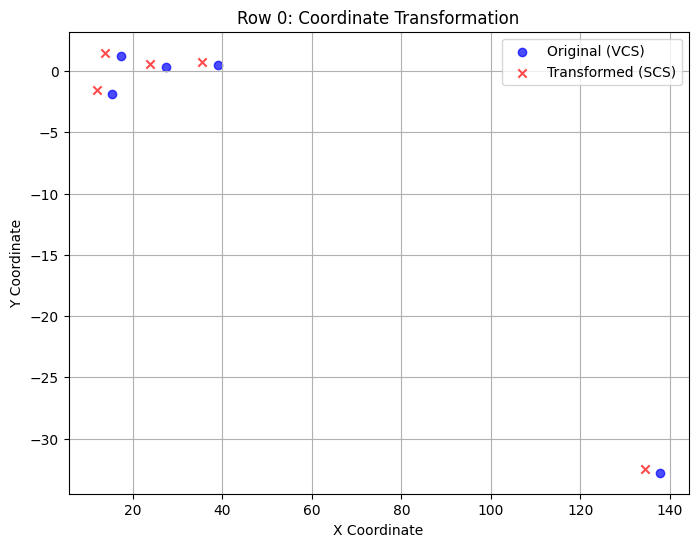

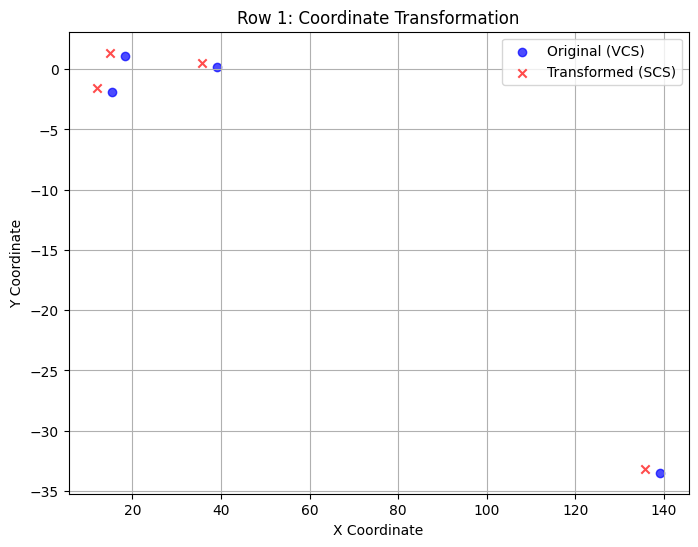

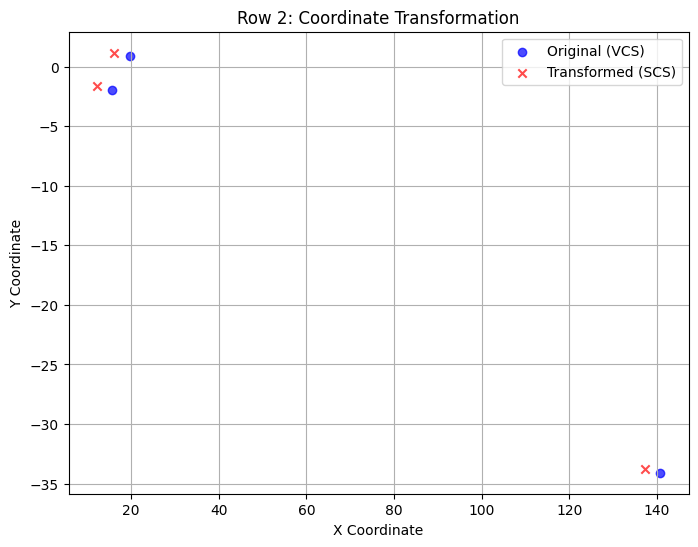

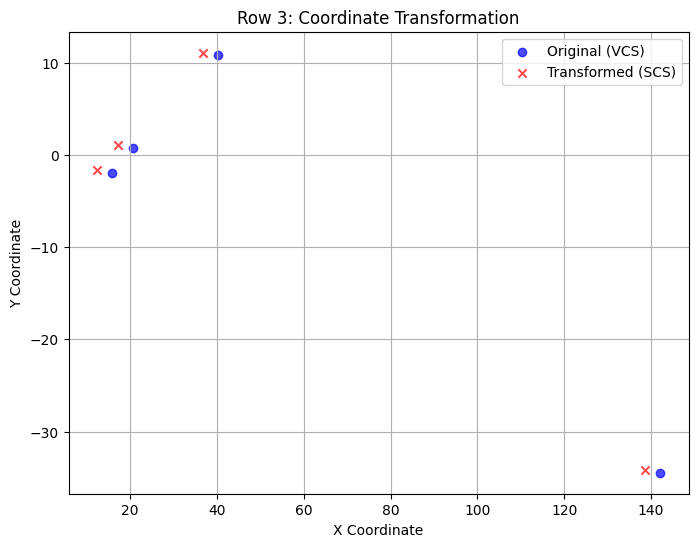

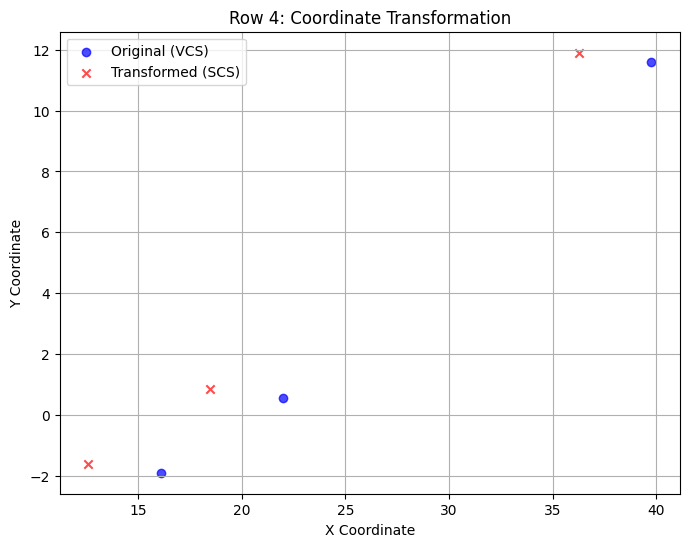

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_transformation_with_conversion(file_path, rows_to_plot=10):
    """
    Plots the old (VCS) and transformed (SCS) coordinates after ensuring they are in a suitable format.
    """
    df = pd.read_pickle(file_path)

    print(f"\n--- Plotting Old vs. Transformed Coordinates ---")

    for idx, row in df.head(rows_to_plot).iterrows():
        try:
            # Extract coordinates
            original_x = row["x"]
            original_y = row["y"]
            transformed_x = row["transformed_x"]
            transformed_y = row["transformed_y"]

            # Ensure they are in list or array format
            if isinstance(original_x, np.ndarray):
                original_x = original_x.tolist()
            if isinstance(original_y, np.ndarray):
                original_y = original_y.tolist()
            if isinstance(transformed_x, np.ndarray):
                transformed_x = transformed_x.tolist()
            if isinstance(transformed_y, np.ndarray):
                transformed_y = transformed_y.tolist()

            # Validate and convert non-list formats
            if not isinstance(original_x, list) or not isinstance(original_y, list):
                print(f"Converting original coordinates for row {idx}.")
                original_x = list(original_x)
                original_y = list(original_y)
            if not isinstance(transformed_x, list) or not isinstance(transformed_y, list):
                print(f"Converting transformed coordinates for row {idx}.")
                transformed_x = list(transformed_x)
                transformed_y = list(transformed_y)

            # Plot the coordinates
            plt.figure(figsize=(8, 6))
            plt.scatter(original_x, original_y, label="Original (VCS)", marker="o", alpha=0.7, color="blue")
            plt.scatter(transformed_x, transformed_y, label="Transformed (SCS)", marker="x", alpha=0.7, color="red")
            plt.title(f"Row {idx}: Coordinate Transformation")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error plotting row {idx}: {e}")

# File path to validate
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_centroid_transformed_combined_frr40_detections_0.p"

# Run the updated plot function
plot_transformation_with_conversion(file_path, rows_to_plot=5)


In [27]:
# Function to create and explain polygons and centroids
def validate_polygon_logic(x, y, ref_point, length, width, orientation):
    """
    Validates polygon and centroid calculation for a single object.
    """
    try:
        orientation_deg = orientation * 180 / np.pi
        print(f"Input Data: x={x}, y={y}, ref_point={ref_point}, length={length}, width={width}, orientation={orientation_deg}°")
        
        # Determine the formula based on the reference point
        if ref_point == 0:
            poly = geometry.Polygon([[x, y], [x - length, y],
                                     [x - length, y - width], [x, y - width]])
            formula = "1. Top-left corner is the reference."
        elif ref_point == 1:
            poly = geometry.Polygon([[x, y + width / 2], [x - length, y + width / 2],
                                     [x - length, y - width / 2], [x, y - width / 2]])
            formula = "2. Middle-left edge is the reference."
        elif ref_point == 2:
            poly = geometry.Polygon([[x, y + width], [x - length, y + width],
                                     [x - length, y], [x, y]])
            formula = "3. Bottom-left corner is the reference."
        elif ref_point == 3:
            poly = geometry.Polygon([[x + length / 2, y + width], [x - length / 2, y + width],
                                     [x - length / 2, y], [x + length / 2, y]])
            formula = "4. Center-top edge is the reference."
        else:
            poly = geometry.Polygon([[x + 1, y + 1], [x - 1, y + 1],
                                     [x - 1, y - 1], [x + 1, y - 1]])
            formula = "5. Default square used for unknown reference point."

        # Rotate polygon based on orientation
        poly = affinity.rotate(poly, orientation_deg, origin=(x, y))
        
        # Compute the centroid
        centroid = (poly.centroid.x, poly.centroid.y)
        print(f"Polygon Formula: {formula}")
        print(f"Computed Centroid: {centroid}")
        return centroid
    except Exception as e:
        print(f"Error processing object: {e}")
        return None

# Select 5 random objects for validation
sample_indices = [0, 1, 2, 3, 4]  # Change indices as needed

for idx in sample_indices:
    row = df.iloc[idx]
    print(f"--- Validation for Row {idx} ---")
    for obj_idx in range(len(row["transformed_x"])):
        print(f"Object {obj_idx}:")
        validate_polygon_logic(
            row["transformed_x"][obj_idx],
            row["transformed_y"][obj_idx],
            row["reference_point"][obj_idx],
            row["length_edge_mean"][obj_idx],
            row["width_edge_mean"][obj_idx],
            row["orientation"][obj_idx]
        )
        print("-" * 50)


--- Validation for Row 0 ---
Object 0:
Input Data: x=23.9060001373291, y=0.6100000143051147, ref_point=1, length=0.17999999225139618, width=2.009999990463257, orientation=-90.00272369384766°
Polygon Formula: 2. Middle-left edge is the reference.
Computed Centroid: (23.906004411347126, 0.7000001667915186)
--------------------------------------------------
Object 1:
Input Data: x=35.43600082397461, y=0.7599999904632568, ref_point=3, length=0.14999999105930328, width=0.6699999570846558, orientation=-90.00272369384766°
Polygon Formula: 4. Center-top edge is the reference.
Computed Centroid: (35.771000802139184, 0.7599840816463903)
--------------------------------------------------
Object 2:
Input Data: x=11.88599967956543, y=-1.5499999523162842, ref_point=3, length=0.32999998331069946, width=0.28999999165534973, orientation=-32.542484283447266°
Polygon Formula: 4. Center-top edge is the reference.
Computed Centroid: (11.963998768917344, -1.4277660105122112)
--------------------------------

In [30]:
def validate_polygon_calculation_step_by_step(x, y, ref_point, length, width, orientation):
    """
    Validates polygon and centroid calculation step-by-step for a single object.
    Shows formulas, substituted values, intermediate steps, and the effect of orientation.
    """
    try:
        orientation_deg = orientation * 180 / np.pi  # Convert radians to degrees
        print(f"\nInput Data:")
        print(f"  x: {x}, y: {y}, ref_point: {ref_point}, length: {length}, width: {width}, orientation: {orientation_deg:.2f}°")

        # Determine polygon points based on reference point
        if ref_point == 0:  # Top-left corner
            poly_points = [
                [x, y], [x - length, y], [x - length, y - width], [x, y - width]
            ]
            formula = "1. Top-left corner: Points: [(x, y), (x - length, y), (x - length, y - width), (x, y - width)]"
        elif ref_point == 1:  # Middle-left edge
            poly_points = [
                [x, y + width / 2], [x - length, y + width / 2],
                [x - length, y - width / 2], [x, y - width / 2]
            ]
            formula = "2. Middle-left edge: Points: [(x, y + width/2), (x - length, y + width/2), (x - length, y - width/2), (x, y - width/2)]"
        elif ref_point == 2:  # Bottom-left corner
            poly_points = [
                [x, y + width], [x - length, y + width], [x - length, y], [x, y]
            ]
            formula = "3. Bottom-left corner: Points: [(x, y + width), (x - length, y + width), (x - length, y), (x, y)]"
        elif ref_point == 3:  # Center-top edge
            poly_points = [
                [x + length / 2, y + width], [x - length / 2, y + width],
                [x - length / 2, y], [x + length / 2, y]
            ]
            formula = "4. Center-top edge: Points: [(x + length/2, y + width), (x - length/2, y + width), (x - length/2, y), (x + length/2, y)]"
        else:  # Default square
            poly_points = [
                [x + 1, y + 1], [x - 1, y + 1], [x - 1, y - 1], [x + 1, y - 1]
            ]
            formula = "5. Default square: Points: [(x + 1, y + 1), (x - 1, y + 1), (x - 1, y - 1), (x + 1, y - 1)]"

        print(f"\nPolygon Formula: {formula}")
        print(f"  Substituted Points: {poly_points}")

        # Rotate the polygon based on orientation
        poly = geometry.Polygon(poly_points)
        rotated_poly = affinity.rotate(poly, orientation_deg, origin=(x, y))
        rotated_points = list(rotated_poly.exterior.coords)[:-1]  # Exclude last repeated point
        print(f"\nEffect of Orientation (Rotation by {orientation_deg:.2f}°):")
        print(f"  Rotated Polygon Points: {rotated_points}")

        # Centroid formula explanation
        print("\nCentroid Calculation:")
        print("  Centroid X = Average of X-coordinates of vertices")
        print("  Centroid Y = Average of Y-coordinates of vertices")
        centroid_x = sum(v[0] for v in rotated_points) / len(rotated_points)
        centroid_y = sum(v[1] for v in rotated_points) / len(rotated_points)
        print(f"  Substituted X-coordinates: {[v[0] for v in rotated_points]}")
        print(f"  Substituted Y-coordinates: {[v[1] for v in rotated_points]}")
        print(f"  Centroid X = {centroid_x:.2f}, Centroid Y = {centroid_y:.2f}")

        # Return the computed centroid
        return (centroid_x, centroid_y)
    except Exception as e:
        print(f"Error processing object: {e}")
        return None


# Validate 5 objects from your dataset
sample_indices = [0, 1, 2, 3, 4]  # Adjust as needed

for idx in sample_indices:
    row = df.iloc[idx]
    print(f"\n--- Validation for Row {idx} ---")
    for obj_idx in range(len(row["transformed_x"])):
        print(f"Object {obj_idx}:")
        validate_polygon_calculation_step_by_step(
            row["transformed_x"][obj_idx],
            row["transformed_y"][obj_idx],
            row["reference_point"][obj_idx],
            row["length_edge_mean"][obj_idx],
            row["width_edge_mean"][obj_idx],
            row["orientation"][obj_idx]
        )
        print("=" * 80)



--- Validation for Row 0 ---
Object 0:

Input Data:
  x: 23.9060001373291, y: 0.6100000143051147, ref_point: 1, length: 0.17999999225139618, width: 2.009999990463257, orientation: -90.00°

Polygon Formula: 2. Middle-left edge: Points: [(x, y + width/2), (x - length, y + width/2), (x - length, y - width/2), (x, y - width/2)]
  Substituted Points: [[23.9060001373291, np.float32(1.615)], [np.float32(23.726), np.float32(1.615)], [np.float32(23.726), np.float32(-0.39499998)], [23.9060001373291, np.float32(-0.39499998)]]

Effect of Orientation (Rotation by -90.00°):
  Rotated Polygon Points: [(24.91100013142749, 0.6099522878516836), (24.91100867946353, 0.7899525928244948), (22.901008691266757, 0.7900480457313535), (22.901000143230714, 0.6100477407585423)]

Centroid Calculation:
  Centroid X = Average of X-coordinates of vertices
  Centroid Y = Average of Y-coordinates of vertices
  Substituted X-coordinates: [24.91100013142749, 24.91100867946353, 22.901008691266757, 22.901000143230714]
  Su